In [ ]:
# Importing librais
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom,
                                     RandomContrast, RandomBrightness)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00
TensorFlow Version: 2.19.0
Keras Tuner Version: 1.4.7
✅ All set up and ready to roll!


Cell -2 connect google drive

In [ ]:
# connect google drive
drive.mount('/content/drive')



print("\nGrabbing the dataset from your Google Drive and moving it locally...")
drive_path = '/content/drive/MyDrive/Colab_Datasets/brain-tumor-mri-dataset'
local_path = '/content/brain-tumor-mri-dataset'

if os.path.exists(local_path):
    shutil.rmtree(local_path)


shutil.copytree(drive_path, local_path)
print("Done.")

Mounted at /content/drive

Grabbing the dataset from your Google Drive and moving it locally...
✅ Awesome! The data is now on the local drive. Training will be way faster.


cell-3 loading and prepare datset here

In [ ]:
train_dir = os.path.join(local_path, 'Training')
test_dir = os.path.join(local_path, 'Testing')

train_csv_path = os.path.join(train_dir, '_annotations.csv')
test_csv_path = os.path.join(test_dir, '_annotations.csv')

col_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']
train_df = pd.read_csv(train_csv_path, header=None, names=col_names)
test_df = pd.read_csv(test_csv_path, header=None, names=col_names)

#need the full path to each image, not just the filename. Let's create that.
train_df['filepath'] = train_df['filename'].apply(lambda file: os.path.join(train_dir, file))
test_df['filepath'] = test_df['filename'].apply(lambda file: os.path.join(test_dir, file))

labels = sorted(train_df['class'].unique().tolist())
label_map = {label: i for i, label in enumerate(labels)}
NUM_CLASSES = len(labels)

#add these new number labels to our dataframes.
train_df['label_encoded'] = train_df['class'].map(label_map)
test_df['label_encoded'] = test_df['class'].map(label_map)


val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index)

#Findings
print(f"We have {NUM_CLASSES} classes: {labels}")
print("\nHere's a sample of our training data info:")
print(train_df.head())
print(f"\nImages for training: {len(train_df)}")
print(f"Images for validation: {len(val_df)}")
print(f"Images for testing: {len(test_df)}")

We have 4 classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

Here's a sample of our training data info:
                                            filename  x_min  y_min  x_max  \
0  Tr-me_0115_jpg.rf.661aa2cbe08aa66e85cbc93abef2...    235    336    340   
1  Tr-pi_0651_jpg.rf.65b66f7ecf2a2fa619ace12b21f9...    246    230    379   
2  Tr-no_0214_jpg.rf.65ff2f100fb3d80b174e88648b3c...    113    117    502   
3  Tr-no_0303_jpg.rf.675351270a549b44cdfbc7c219cb...    168    125    481   
4  Tr-no_0036_jpg.rf.65da5be208dc97700ee464b3d950...    178     81    421   

   y_max       class                                           filepath  \
0    420  Meningioma  /content/brain-tumor-mri-dataset/Training/Tr-m...   
1    316   Pituitary  /content/brain-tumor-mri-dataset/Training/Tr-p...   
2    456    No Tumor  /content/brain-tumor-mri-dataset/Training/Tr-n...   
3    523    No Tumor  /content/brain-tumor-mri-dataset/Training/Tr-n...   
4    601    No Tumor  /content/brain-tumor-mri-da

Cell-4 Cheking datasets

/tmp/ipython-input-3660318360.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='class', data=train_df, palette='viridis', order=labels)
/tmp/ipython-input-3660318360.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='class', data=val_df, palette='plasma', order=labels)
/tmp/ipython-input-3660318360.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[2], x='class', data=test_df, palette='magma', order=labels)


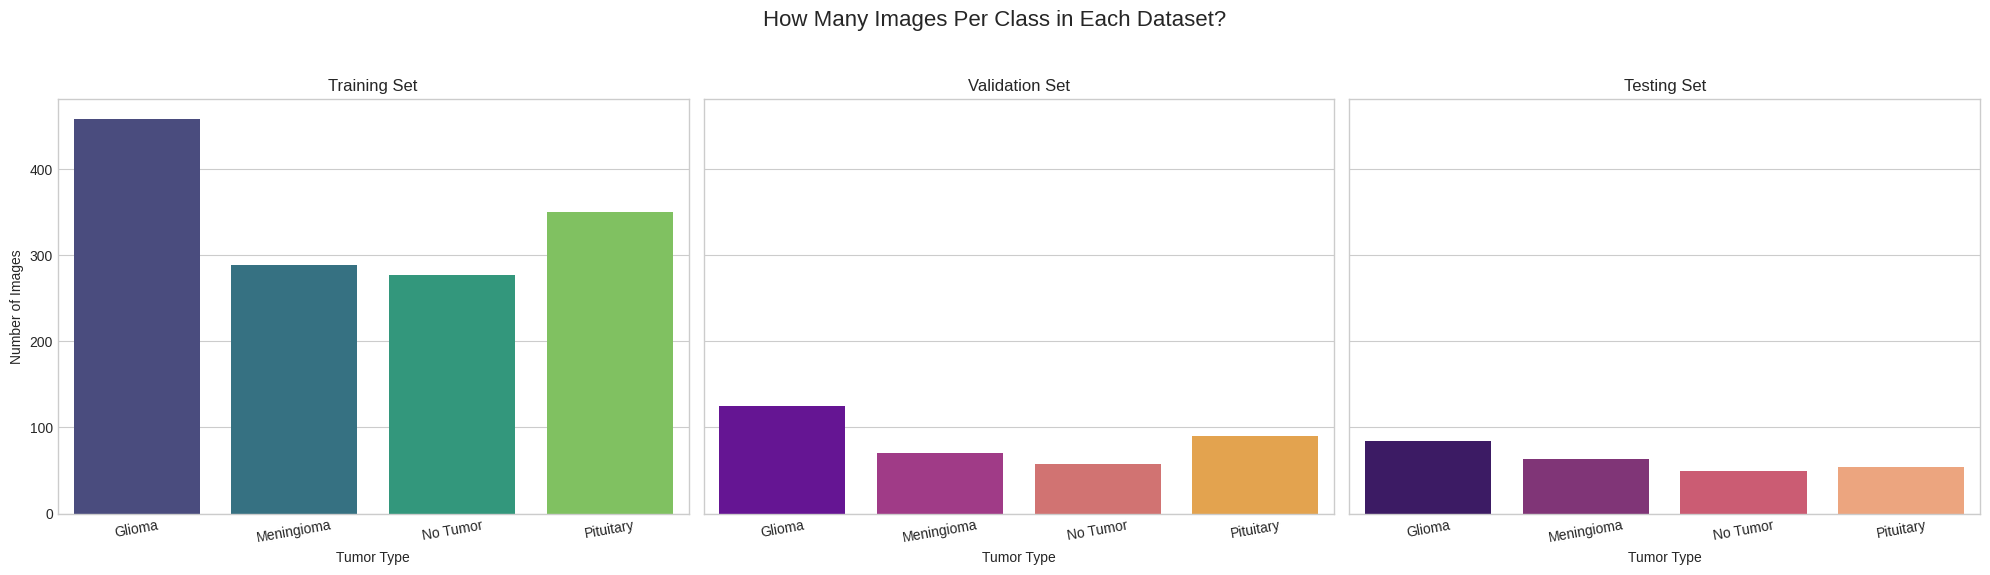

In [ ]:

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('How Many Images Per Class in Each Dataset?', fontsize=16)

sns.countplot(ax=axes[0], x='class', data=train_df, palette='viridis', order=labels)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Tumor Type')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=10)

# Chart for the Validation Set
sns.countplot(ax=axes[1], x='class', data=val_df, palette='plasma', order=labels)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Tumor Type')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=10)

# Chart for the Testing Set
sns.countplot(ax=axes[2], x='class', data=test_df, palette='magma', order=labels)
axes[2].set_title('Testing Set')
axes[2].set_xlabel('Tumor Type')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', rotation=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Cell-5 uilding a Super-Fast Data Pipeline

In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.applications.efficientnet import preprocess_input

def parse_image(filepath, label):
    """This little function just loads and prepares a single image."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, label

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
], name='data_augmentation')

def build_dataset(df, shuffle=False, augment=False):
    """This function puts everything together into a complete data pipeline."""
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label_encoded'].values))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Re-build the datasets with the new preprocessing step.
train_ds = build_dataset(train_df, shuffle=True, augment=True)
val_ds = build_dataset(val_df)
test_ds = build_dataset(test_df)

print("Data pipelines are updated and ready for EfficientNet!")

✅ Data pipelines are updated and ready for EfficientNet!


cell-6 FIGUREThe Augmentation

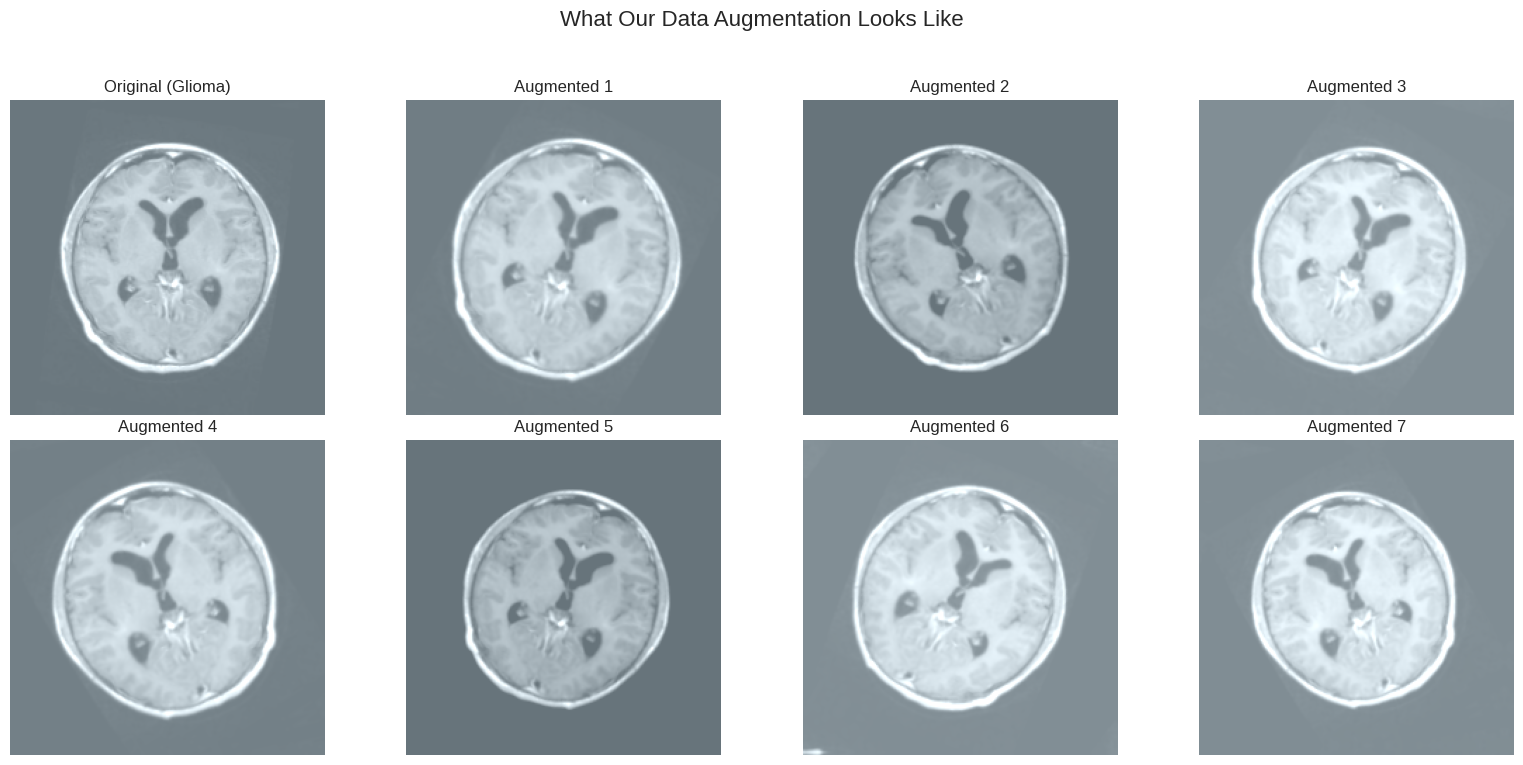

In [ ]:

for images, labels_onehot in train_ds.take(1):
    plt.figure(figsize=(16, 8))
    plt.suptitle("What Our Data Augmentation Looks Like", fontsize=16)
    first_image = images[0]
    first_label = labels[tf.argmax(labels_onehot[0])]

    def denormalize(img):
        img = img.numpy().copy()
        img += [123.68, 116.779, 103.939]
        img = img[..., ::-1] # Switches from BGR back to RGB
        return np.clip(img / 255.0, 0, 1)

    # Show the original image on the left.
    plt.subplot(2, 4, 1)
    plt.imshow(denormalize(first_image))
    plt.title(f"Original ({first_label})")
    plt.axis('off')

    for i in range(7):
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.subplot(2, 4, i + 2)
        plt.imshow(denormalize(augmented_image[0]))
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    break

Cell -7 : Cheking and fitting the Model for the Tuner


In [ ]:

from tensorflow.keras.applications import EfficientNetB0

def build_hyper_model(hp):
    """This function builds our new, more powerful model."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    base_model.trainable = False

    # Now, let's build our custom classifier head on top of it.
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        # First dense layer.
        Dense(
            units=hp.Int('units_1', min_value=256, max_value=512, step=128),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        # Second dense layer for more learning power.
        Dense(
            units=hp.Int('units_2', min_value=128, max_value=256, step=128),
            activation='relu'
        ),
        # Our final output layer.
        Dense(NUM_CLASSES, activation='softmax')
    ])

    # Let's stick with a stable learning rate search.
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("EfficientNetB0 model is ready!")

✅ Our new EfficientNetB0 model blueprint is ready!


cell : 7.5 fixing accuracy

In [ ]:

from sklearn.utils.class_weight import compute_class_weight

class_labels_for_weights = np.unique(train_df['label_encoded'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_for_weights,
    y=train_df['label_encoded']
)


class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Calculated Class Weights:")
for i, label in enumerate(labels):
    print(f"  - {label}: {class_weight_dict[i]:.2f}")
print("\nThe model will now pay more attention to classes with higher weights.")

Calculated Class Weights:
  - Glioma: 0.75
  - Meningioma: 1.19
  - No Tumor: 1.24
  - Pituitary: 0.98

The model will now pay more attention to classes with higher weights.


Cell 8: Let the Tuner Do Its Magic

In [ ]:


tuner = kt.RandomSearch(
    build_hyper_model,
    objective='val_accuracy',
    max_trials=5,          # Let's try 5 combinations instead of 3 duo to low accuracy.
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='brain_tumor_vgg16_balanced' # A new name for our balanced run
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("--- Starting the BALANCED Hyperparameter Search! ---")
print("This will take a little longer than the last run, but should give better results.")
tuner.search(train_ds, epochs=15, validation_data=val_ds, callbacks=[stop_early])
print("\n--- Search Complete! ---")

#Highest combo.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nAnd the winner is...")
print(f"  - Neurons: {best_hps.get('units')}")
print(f"  - Dropout: {best_hps.get('dropout'):.2f}")
print(f"  - Optimizer: {best_hps.get('optimizer')}")
print(f"  - Learning Rate: {best_hps.get('learning_rate')}")

Reloading Tuner from tuner_dir/brain_tumor_vgg16_balanced/tuner0.json
--- Starting the BALANCED Hyperparameter Search! ---
This will take a little longer than the last run, but should give better results.

--- Search Complete! ---

And the winner is...
  - Neurons: 256
  - Dropout: 0.30
  - Optimizer: rmsprop
  - Learning Rate: 0.0001


Cell-9 Building and Training Our Final Model

In [ ]:

print("\n--- Building the final model with our winning settings ---")
model = tuner.hypermodel.build(best_hps)

print("\nOur Final Model's Architecture:")
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
display(plt.imread('model_architecture.png'))

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, # More patient, giving it time to learn
    restore_best_weights=True
)

print("\n--- Phase 1: Training our custom head ---")
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler]
)

print("\n--- Phase 2: Fine-tuning the top layers of EfficientNet ---")
base_model = model.layers[0]
base_model.trainable = True


for layer in base_model.layers[:-20]:
    layer.trainable = False

optimizer = Adam(learning_rate=best_hps.get('learning_rate') / 10)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"\nModel re-compiled for fine-tuning.")
model.summary()

# Let's continue training.
fine_tune_epochs = 30
total_epochs = len(history.epoch) + fine_tune_epochs

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler]
)
print("\n--- All training is done! Let's check the final accuracy. ---")


--- Building the final model with our winning settings ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Our Final Model's Architecture:


array([[[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 0.6666667]],

       [[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 0.6666667]],

       [[1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        ...,
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.       , 1.       ],
        [1.       , 1.       , 1.      


--- Phase 1: Training our custom head ---
Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4338 - loss: 1.2736 - val_accuracy: 0.6880 - val_loss: 0.9245 - learning_rate: 1.0000e-04
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 351ms/step - accuracy: 0.7086 - loss: 0.8643 - val_accuracy: 0.7493 - val_loss: 0.7021 - learning_rate: 1.0000e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.7980 - loss: 0.6577 - val_accuracy: 0.7755 - val_loss: 0.5892 - learning_rate: 1.0000e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - accuracy: 0.8377 - loss: 0.4901 - val_accuracy: 0.7464 - val_loss: 0.5952 - learning_rate: 1.0000e-04
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.8346 - loss: 0.4942 - val_accuracy: 0.7609 - val_loss: 0.5408 - learning_rate: 1.0000e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.8574 - loss: 0.4316 - val_accuracy: 0.7930 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 7/30
43/43 ━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,919 (16.83 MB)

 Trainable params: 1,712,308 (6.53 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

Epoch 28/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 944ms/step - accuracy: 0.7739 - loss: 0.6861 - val_accuracy: 0.8367 - val_loss: 0.3592 - learning_rate: 1.0000e-05
Epoch 29/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.8353 - loss: 0.5832 - val_accuracy: 0.8571 - val_loss: 0.3596 - learning_rate: 1.0000e-05
Epoch 30/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.8526 - loss: 0.5259 - val_accuracy: 0.8571 - val_loss: 0.3749 - learning_rate: 1.0000e-05
Epoch 31/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8871 - loss: 0.4563
Epoch 31: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.8869 - loss: 0.4565 - val_accuracy: 0.8542 - val_loss: 0.3872 - learning_rate: 1.0000e-05
Epoch 32/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.8688 - loss: 0.4480 - val_accuracy: 0.8455 - val_loss: 0.4109 - learning_rate: 2.0000e-06
Epoch 33/58
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - a

Cell 10: FIGURE - Charting Our Training Progress


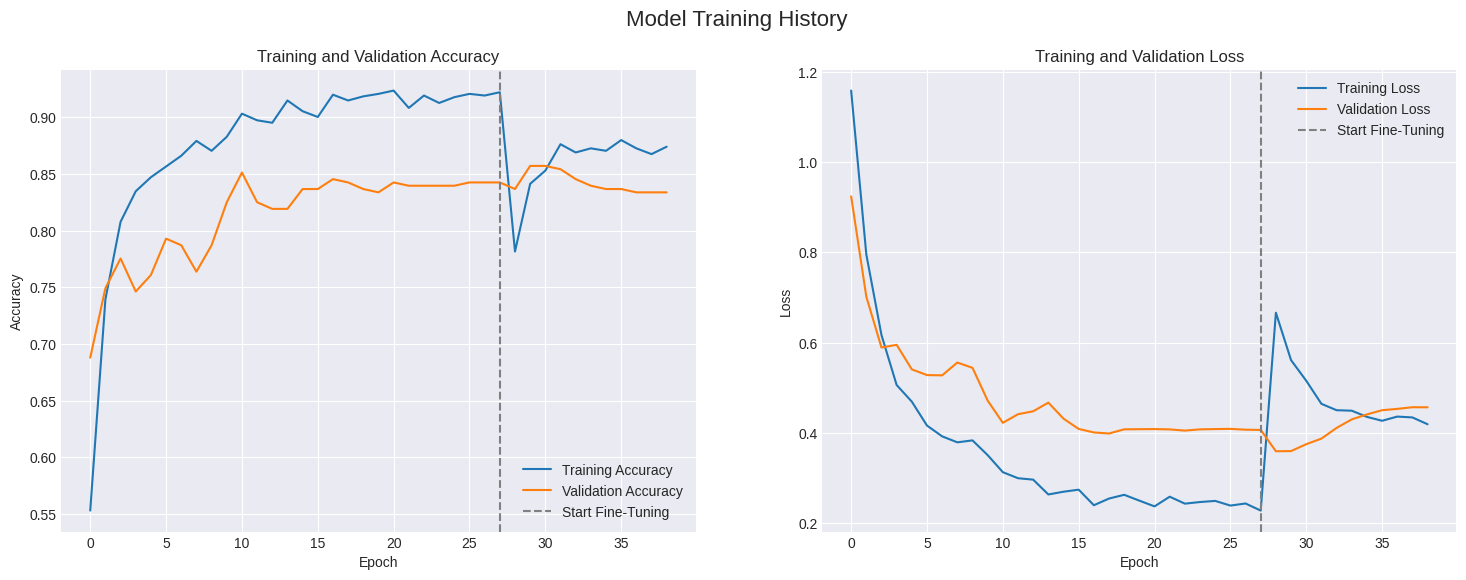

In [ ]:

acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

epochs_range = range(len(acc))

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# The accuracy plot
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
# This line shows where the fine-tuning started
if len(history.epoch) > 0:
    ax1.axvline(x=len(history.epoch)-1, color='grey', linestyle='--', label='Start Fine-Tuning')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

# The loss plot
ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
# This line shows where the fine-tuning started
if len(history.epoch) > 0:
    ax2.axvline(x=len(history.epoch)-1, color='grey', linestyle='--', label='Start Fine-Tuning')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

fig.suptitle('Model Training History', fontsize=16)
plt.show()

Cell 11: The Final Exam: Evaluating on the Test Set


In [ ]:


print( Evaluating the final model on the test data ")
test_loss, test_acc = model.evaluate(test_ds)

print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

print("\nGetting the model's predictions...")
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

--- Evaluating the final model on the test data ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7899 - loss: 0.5516

Final Test Accuracy: 79.60%
Final Test Loss: 0.4888

Getting the model's predictions...


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 909ms/step


Cell 12: FIGURE - The Confusion Matrix


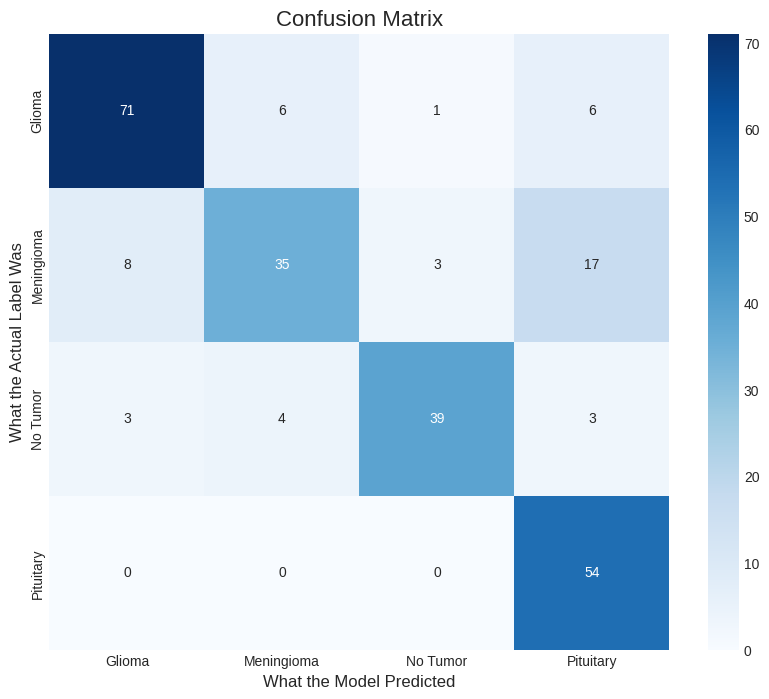

In [ ]:


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('What the Model Predicted', fontsize=12)
plt.ylabel('What the Actual Label Was', fontsize=12)
plt.show()

Cell 13: The Detailed Classification Report


In [ ]:


print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60 + "\n")
print(classification_report(y_true, y_pred, target_names=labels))


           CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Glioma       0.87      0.85      0.86        84
  Meningioma       0.78      0.56      0.65        63
    No Tumor       0.91      0.80      0.85        49
   Pituitary       0.68      1.00      0.81        54

    accuracy                           0.80       250
   macro avg       0.81      0.80      0.79       250
weighted avg       0.81      0.80      0.79       250



cell 14

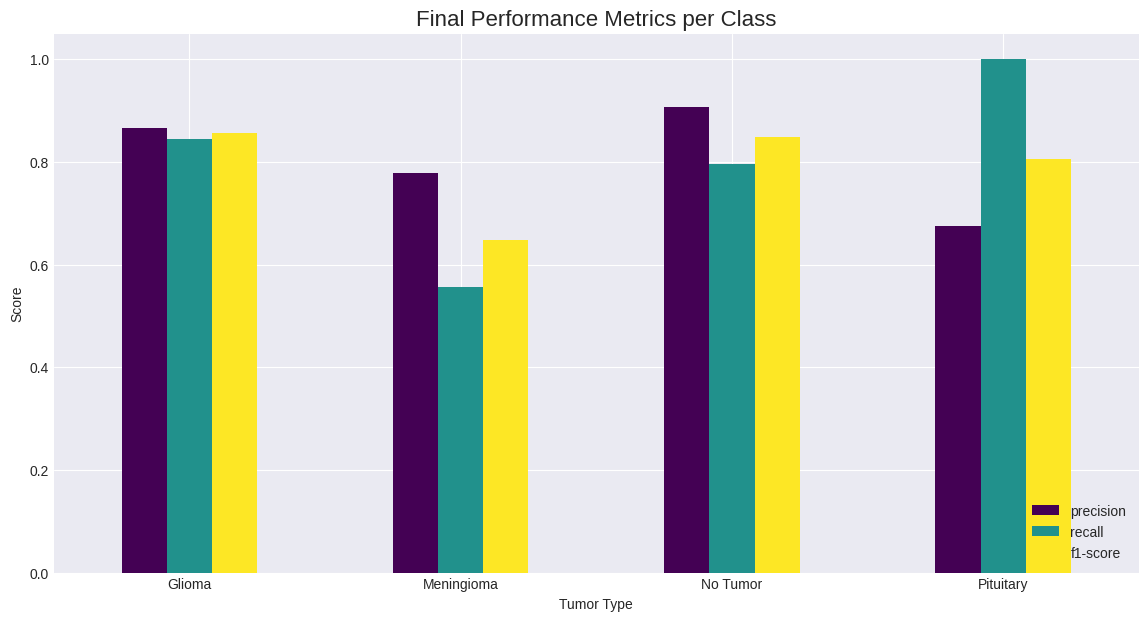

In [ ]:

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

report_df.plot(y=['precision', 'recall', 'f1-score'],
               kind='bar',
               figsize=(14, 7),
               colormap='viridis')

plt.title('Final Performance Metrics per Class', fontsize=16)
plt.xlabel('Tumor Type')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()